<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2025notebooks/2024_0626Knd_Ijn_Ask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 2025 年 05 月 01 日時点でのメモ
# numpy のバージョンを強制的に 1.26.4 にダウングレードした場合，ランタイムの再起動をしないと
# ダウングレードした numpy が実行時に反映されない。
# このため一度このセルを実行した後に,上のメニューバー左から 5 つ目の「ランタイム」から「セッションを再起動する」
# を選択して再度このセルを実行する必要がある。

# Google Colab 上で実行しているかどうかを判定
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

# Google colab で実行している場合必要なライブラリをインストールして word2vec ファイルをダウンロードする
if isColab:
    # Install PyDrive
    !pip install pydrive2
    #!pip install PyDrive2

    #Import modules
    from pydrive2.auth import GoogleAuth
    #from pydrive.auth import GoogleAuth
    from pydrive2.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    #Authenticate and create the PyDrive client
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    #Get the Shareable link
    # 2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz: 1Rp3HbDkbpzMg5ehq1ARwCATX8iZAxTgj
    # 2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_sgns.bin.gz: 19BKVOBNHESt1K8725UTM9J3OpqK7YlVb
    downloaded = drive.CreateFile({'id':"1Rp3HbDkbpzMg5ehq1ARwCATX8iZAxTgj"})
    downloaded.GetContentFile('2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz')

    # 2021_05jawiki_hid200_win20_neg20_sgns.bin.gz: 1JTkU5SUBU2GkURCYeHkAWYs_Zlbqob0s
    # 2021_05jawiki_hid200_win20_neg20_cbow.bin.gz: 1VPL2Mr9JgWHik9HjRmcADoxXIdrQ3ds7
    # 2021_05jawiki_hid128_win10_neg10_sgns.bin.gz: 1OWmFOVRC6amCxsomcRwdA6ILAA5s4y4M
    # 2021_05jawiki_hid128_win10_neg10_cbow.bin.gz: 1B9HGhLZOja4Xku5c_d-kMhCXn1LBZgDb
    # 上記は cbow で訓練済ファイルをダウンロードしています。
    # skip gram モデルで訓練済モデルに変更する場合には，上記情報に従って 27 行目と 28 行目を書き換えてください。

    !pip uninstall numpy thinc spacy --yes
    !pip install --upgrade numpy==1.26.4 --force-reinstall
    !pip install --upgrade gensim==4.3.3
    #!pip install --upgrade numpy==1.26.4 gensim==4.3.3 --force-reinstall

    import numpy as np
    print(f'np.__version__:{np.__version__}')

    import gensim
    print(f'gensim.__version__:{gensim.__version__}')


import numpy as np
from gensim.models import KeyedVectors

w2v = KeyedVectors.load_word2vec_format(
    '2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz',
    encoding='utf-8',
    unicode_errors='replace',
    binary=True)

# # 以下は動作確認です。
# # 埋め込みベクトルを得る
# print(w2v['心理学'])

# # 最も近い単語を得る
# print(w2v.most_similar('認知科学'))

In [ ]:
%config InlineBackend.figure_format = 'retina'
import torch

# 利用可能な GPU device の検出と設定
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device:{device}')

# 必要なライブラリの輸入
import sys
import os
import numpy as np
from tqdm.notebook import tqdm
import time
import datetime
import matplotlib.pyplot as plt

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

try:
    import jaconv
except ImportError:
    !pip install jaconv
    import jaconv

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

device:cpu


* date: 2023_1027
* author: 浅川伸一
* filename: 2024_0528Knd_Ijn_Ask.ipynb 名前変更，旧名は `2023_1027Knd_Ijn_Ask_s2p_p2s.ipynb` 理由は orthgraphy も追加したから。

## 覚書

# 符号化器‐復号化器 (encoder-decoder a.k.a seq2seq) モデルによる，単語認識過程 beyond triangle

`fit_seq2seq()`, `eval_seq2seq()` は，encoder 側が 系列データでも，埋め込みベクトルでも動作する。
従って，o2o, o2p, p2o, p2p, s2o, s2p の 6 モデルはこれで良いようだ。
残された，o2s, p2s, s2s を開発すれば良い。

<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2006Kello_fig4.svg" style="width:39%">
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2006Kello_junction_fig5.svg" style="width:39%">
<!-- <img src="2006Kello_fig4.svg" width="39%"><img src="2006Kello_junction_fig5.svg" style="width:39%"> -->
<div style="background-color:lavender;text-align:left;width:66%">
左: RNN を用いた符号化器 (encoder) -復号化器 (decoder) モデル。
右: Kello らの結節点 (junction) モデル。中央の語彙ノード (lexical nodes) 上の数字 45263 は，交差点モデルが扱うことが可能な語彙数。<br/>
左: Kello+2006 Fig.4, 右: Kello+2006 Fig5
</div>
</center>


<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig1_extended.svg" style="width:39%">
<!-- <img src="2004Harm_Seidenberg_fig1_extended.svg" width="39%"> -->
<div style="background-color:lavender;text-align:center;width:44%">
Harm\&Seidenberg2004 Fig. 1 を改変。
</div>
</center>

1. O(rthgraphy), P(honology), S(emnatics) のそれぞれに対して，ソースとターゲットと見立てた，9 つのデータセット，モデルを用意した。
モデル名を下表に示す。
表中の x2y は，ソースが x [o,p,s] でターゲットが y [o,p,s] であるモデルを意味する。
カッコ内は，ソースとターゲットのそれぞれが，系列データであれば Seq であり，埋め込みベクトルデータであれば Vec である。

|source\target   | O   | P   |  S |
|:--:|:--:|:---:|:--:|
| O | o2o (Seq2seq)| o2p (Seq2Seq)| o2s (Seq2Vec)|
| P | p2o (Seq2Seq)| p2p (Seq2Seq)| p2s (Seq2Vec)|
| S | s2o (Vec2Seq)| s2p (Vec2Seq)| s2s (Vec2Vec)|

ソースからターゲットへと系列データかベクトル埋め込みデータかによって，モデルは 4 種類に分類できる。

1. 系列から系列へ: 4 (o2o, o2p, p2o, p2p)，
2. 系列からベクトル埋め込みへ: 2 (o2s, p2s)
3. ベクトル埋め込みから系列へ: 2 (s2o, s2p)
4. ベクトル埋め込みからベクトル埋め込み 1

## メモ

1. 2023_1027 に近藤先生には，このコードのプロトタイプをお見せした。
すなわち GitHub にアップロード済である。
このファイルには，その後の改良が加えられている。
ただし，最初のセルで MeCab をソースコードからダウンロードして，コンパイル & インストールに時間を要したため，実施まではお見せしていない。

2. MeCab の使用は，未知語が入力として与えられた場合，仮のヨミを得るために使用している。
上記の役割を除けば MeCab は不要だと判断し，MeCab の使用を中止した


<center>
<!-- <img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/> -->
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4ab.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg">
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1999Levelt_blueprint.jpg" width=49%"><br/>
<!-- <img src="2004Harm_Seidenberg_fig4ab.svg"><br/>
<img src="2004Harm_Seidenberg_fig4c.svg">
<img src="2004Harm_Seidenberg_fig4d.svg"><br/> -->
`Harm & Seidenberg (2004)`, Figure 4 c, and d,
`Levelt 1999
</center>

<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2015Loung_fig1.svg" width="24%"><br/>
ニューラル翻訳モデル。
青色がソース言語モデル，赤がターゲット言語モデルである。
ソース言語モデルの，最終時刻の中間層状態を，ターゲット言語モデルの開始時の中間層状態として用いる。
Loung+2015 Fig.1 より。    
</center>


* 文献
    * Harm & Seidenberg (2004) Computing the Meanings of Words in Reading: Cooperative Division of Labor Between Visual and Phonological Processes, Psychological Review, DOI:10.1037/0033-295X.111.3.662
    * Seq2seq 翻訳モデル: Sutskever+ (2014) Sequence to Sequence Learning with Neural Networks, [arXiv:1409.3215](https://arxiv.org/abs/1409.3215)
    * 注意つき符号化器‐復号化器モデル: Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, [arXiv:1409.0473](https://arxiv.org/abs/1409.0473)
    * もう一つの注意つき符号化器‐復号化器モデル Luong+ (2015) Effective Approaches to Attention-based Neural Machine Translation, [arXiv:1508.04025](https://arxiv.org/abs/1508.04025)


# 準備

## 自作ライブラリの輸入

In [ ]:
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

try:
    import RAM
except ImportError:
    !git clone https://github.com/ShinAsakawa/RAM.git
    import RAM

# 近藤先生との議論から音韻情報の代替案として，ローマ字表記を採用することとした。
# このとき，訓令式の表記にすることとした。ヘボン式，パスポート式ではないことに注意
try:
    from kunrei import kunrei
except ImportError:
    !wget https://shinasakawa.github.io/2023notebooks/kunrei.py -O kunrei.py
    from kunrei import kunrei

## 意味表現として word2vec による意味埋め込みベクトルを使う

In [ ]:
RAMja_chars = RAM.ja_chars()
# print(f'len(RAMja_chars):{len(RAMja_chars)}')
# print(f'type(RAMja_chars):{type(RAMja_chars)}')

w2v_chars = {}
for word in w2v.index_to_key[1:]:
    for ch in word:
        if not ch in w2v_chars:
            w2v_chars[ch] = 1
        else:
            w2v_chars[ch] += 1

print(f'len(w2v_chars):{len(w2v_chars)} word2vec で用いられれている文字総数')

len(w2v_chars):11884 word2vec で用いられれている文字総数


<Figure size 1400x400 with 0 Axes>

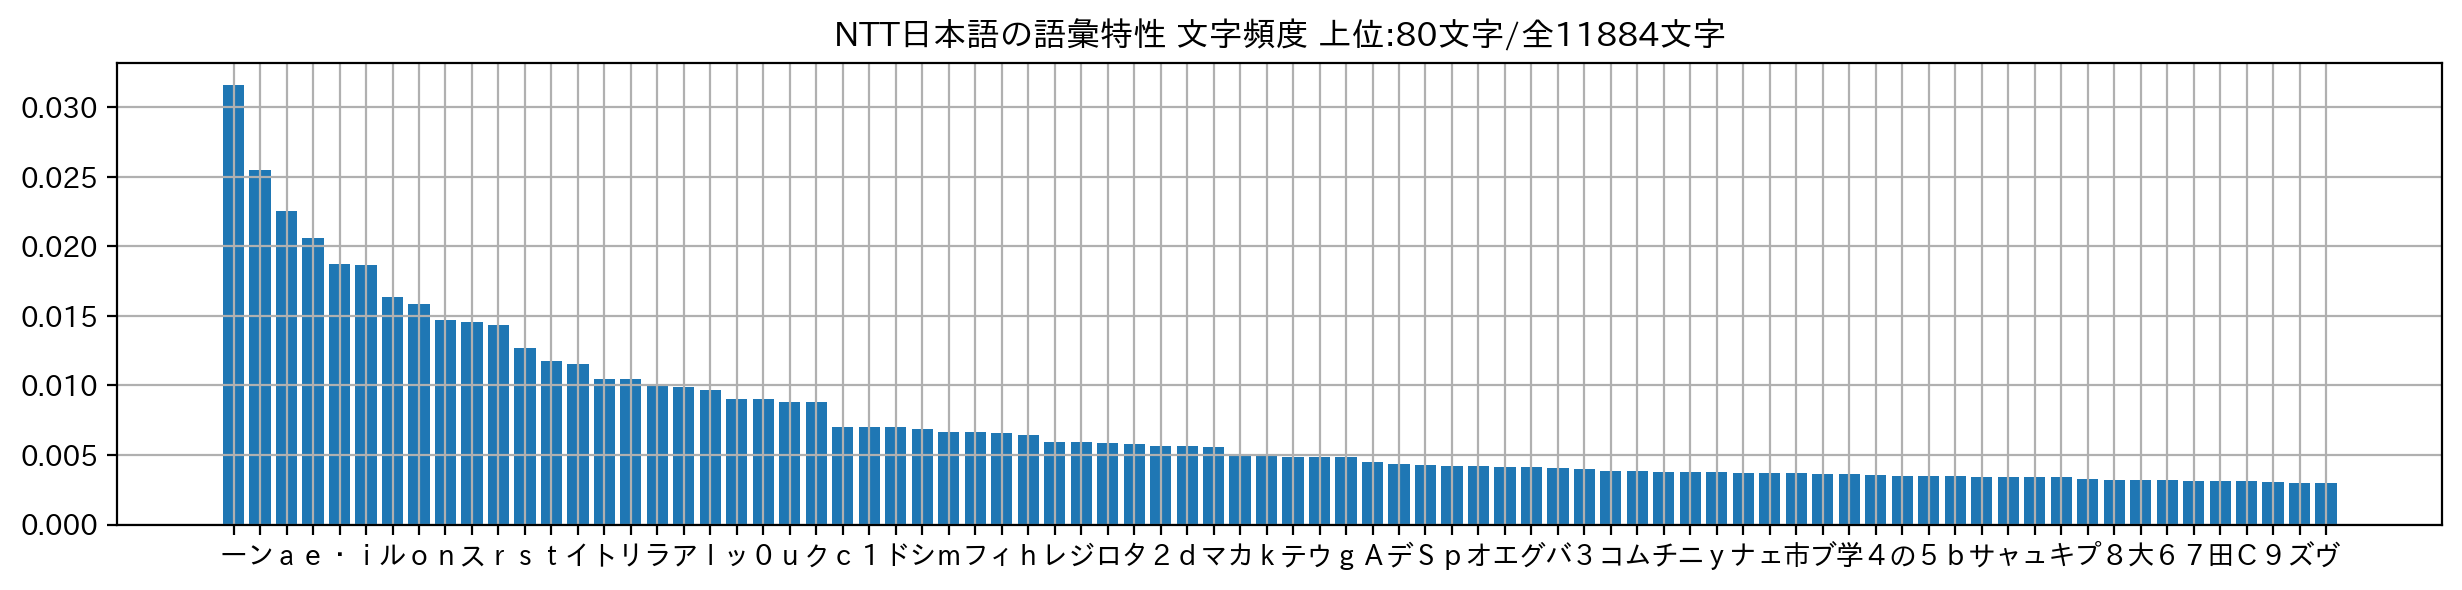

In [ ]:
import operator

count_sorted = sorted(w2v_chars.items(), key=operator.itemgetter(1), reverse=True)
plt.figure(figsize=(14,4))
N = np.array([x[1] for x in w2v_chars.items()]).sum()

topN = 80
title = f'NTT日本語の語彙特性 文字頻度 上位:{topN}文字/全{len(w2v_chars)}文字'
plt.figure(figsize=(15,3))
plt.bar(range(len(count_sorted[:topN])), [x[1]/N for x in count_sorted[:topN]])
plt.xticks(ticks=range(len(count_sorted[:topN])), labels=[c[0] for c in count_sorted[:topN]])
plt.title(title)
plt.grid()
plt.show()

In [ ]:
kanji_end = 10892
kanji_start = kanji_end - 9200
kanji_start = 900
#print(chrs[kanji_start:kanji_start+1900])
#print(chrs[kanji_end-9500:kanji_end+1])
print(f'kanji_start:{kanji_start}')
print(f'kanji_end  :{kanji_end}')

chars_cands  = list(sorted(set(w2v_chars.keys())))[886:914] # [kanji_start:kanji_end+1]
print(f'chars_cands:{chars_cands}')
print(f'削除した文字記号{list(sorted(set(w2v_chars.keys())))[914:947]}')
chars_cands += list(sorted(set(w2v_chars.keys())))[947:1024] # [kanji_start:kanji_end+1]
print(f'len(chars_cands):{len(chars_cands)}')
print(chars_cands[:120], kanji_start, kanji_end)

kanji_start:900
kanji_end  :10892
chars_cands:['थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'े', 'ै', 'ो', '्', 'ॐ']
削除した文字記号['।', '१', 'ং', 'আ', 'ক', 'গ', 'জ', 'ঢ', 'ত', 'দ', 'ধ', 'ন', 'প', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ে', 'ো', '্', 'ਗ', 'ਘ', 'ਰ']
len(chars_cands):105
['थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'े', 'ै', 'ो', '्', 'ॐ', 'ਸ', 'ਿ', 'ੁ', 'ੂ', 'ੰ', 'ઈ', 'ક', 'જ', 'ટ', 'ત', 'દ', 'ન', 'પ', 'ભ', 'ર', 'લ', 'વ', 'શ', 'હ', 'ા', 'ે', '્', 'அ', 'ஆ', 'இ', 'ஈ', 'ஐ', 'க', 'ங', 'ச', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ா', 'ி', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', '்', 'గ', 'ఘ', 'చ', 'త', 'ద', 'ప', 'య', 'ర', 'ల', 'వ', 'ా', 'ి', 'ు', 'ూ', 'ె', 'ో', '్', 'ಂ', 'ಒ', 'ಕ', 'ಗ', 'ಙ'] 900 10892


In [ ]:
print(list(sorted(set(w2v_chars.keys())))[1170:1777])

['ະ', 'ັ', 'າ', 'ຳ', 'ິ', 'ົ', 'ເ', 'ໄ', 'ໍ', '་', 'ཀ', 'ག', 'ང', 'ཆ', 'ཏ', 'ད', 'ན', 'པ', 'བ', 'མ', 'ཞ', 'འ', 'ཡ', 'ར', 'ལ', 'ས', 'ཨ', 'ི', 'ུ', 'ེ', 'ོ', 'ྒ', 'ྱ', 'က', 'ခ', 'င', 'စ', 'ည', 'တ', 'ထ', 'န', 'ပ', 'ဘ', 'မ', 'ယ', 'ရ', 'လ', 'ာ', 'ိ', 'ု', 'ေ', 'ံ', '့', 'း', '်', 'ြ', 'ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'შ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ል', 'ሕ', 'ራ', 'ር', 'ቀ', 'በ', 'ባ', 'ት', 'አ', 'ኢ', 'ኤ', 'ክ', 'ዞ', 'የ', 'ያ', 'ይ', 'ዮ', 'ጵ', '᛫', '᛬', 'ក', 'ង', 'ច', 'ជ', 'ដ', 'ណ', 'ត', 'ទ', 'ន', 'ប', 'ព', 'ម', 'រ', 'ល', 'វ', 'ស', 'អ', 'ា', 'ឹ', 'ុ', 'ែ', 'ោ', 'ះ', '្', 'ᠠ', 'ᠣ', 'ᠨ', 'ᠰ', 'ᠶ', 'ᡞ', 'ᡠ', 'ᡥ', 'ᡧ', 'ᡳ', 'ᵝ', 'ḍ', 'ḏ', 'Ḑ', 'ḡ', 'Ḥ', 'ḥ', 'Ḫ', 'ḫ', 'ḱ', 'ḷ', 'ḹ', 'ḻ', 'ḿ', 'ṃ', 'ṅ', 'Ṇ', 'ṇ', 'ṛ', 'ṝ', 'ṟ', 'Ṣ', 'ṣ', 'Ṭ', 'ṭ', 'ṯ', 'ṳ', 'Ẓ', 'ẓ', 'ạ', 'ả', 'ấ', 'ầ', 'ẩ', 'ậ', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ', 'ẻ', 'Ẽ', 'ẽ', 'ế', 'ề', 'ể', 'ễ', 'ệ', 'ỉ', 'ị', 'ọ', 'ỏ', 'ố', 'ồ', 'ổ', 'ỗ', 'ộ', 'ớ', 'ờ', 'ở', 'ợ',

In [ ]:
# 2024 年後期に使った文字と word2vec との差分を求める
not_in_RAMjachars = []
in_RAMjachars = []
for ch in chars_cands:
    if ch in RAMja_chars.all_chars:
        in_RAMjachars.append(ch)      # RAM (2024年後期 cnps 沖縄) に存在した文字
        #in_RAMjachars += ch      # RAM (2024年後期 cnps 沖縄) に存在した文字
    else:
        not_in_RAMjachars.append(ch)  # RAM に存在しない文字
        #not_in_RAMjachars += ch  # RAM に存在しない文字

# RAM に存在しない文字列をもう一度変換
not_in_RAMjachars = sorted(set(not_in_RAMjachars))
# _not_in_RAMjachars = ""
# for ch in not_in_RAMjachars:
#     _not_in_RAMjachars += ch
# not_in_RAMjachars = _not_in_RAMjachars

print(f'len(w2v_chars):{len(w2v_chars)} word2vec で用いられれている文字総数')
print(f'len(RAMja_chars.all_chars):{len(RAMja_chars.all_chars)} RAM 2024 年夏時点での登録文字数')
print(f'len(not_in_RAMjachars):{len(not_in_RAMjachars)}')

#print(f'len(RAMja_chars.all_chars):{RAMja_chars.all_chars}')
#print(RAMja_chars.all_chars)
#print(not_in_RAMjachars)
#A = sorted(set(RAMja_chars.all_chars))
#B = sorted(set(w2v_chrs))
#print(set(A) - set(B)) # - set(B))
#RAMja_chars.all_chars
#print(w2v_chars)

#print(len(sorted(RAMja_chars.all_chars + not_in_RAMjachars)))
#print(len(sorted(set(RAMja_chars.all_chars + not_in_RAMjachars))))

counter = 0
for ch in not_in_RAMjachars:
    if ch in RAMja_chars.all_chars:
        counter += 1
        print(ch, end="")

print(len(RAMja_chars.all_chars)+len(not_in_RAMjachars))
print(f'counter:{counter}')

len(w2v_chars):11884 word2vec で用いられれている文字総数
len(RAMja_chars.all_chars):2559 RAM 2024 年夏時点での登録文字数
len(not_in_RAMjachars):105
2664
counter:0


In [ ]:
A = sorted(set(RAMja_chars.all_chars)) # or set(not_in_RAMjachars))
B = sorted(set(not_in_RAMjachars))

# for ch in A:
#     if not ch in B:
#         print(ch)

print(f'len(A):{len(A)}, len(B):{len(B)}')
print(A[:3], B[:3])
print(RAMja_chars.all_chars[:3])
print(not_in_RAMjachars[:3])

len(A):2465, len(B):105
['!', '"', '#'] ['थ', 'द', 'ध']
!"#
['थ', 'द', 'ध']


## データセット Psylex71_Dataset の読み込み

In [ ]:
# データセットとしての Psylex71_Dataset の読み込み
from RAM import Psylex71_Dataset

psylex71_ds = Psylex71_Dataset(max_words=30000)
print(f'psylex71_ds の単語数:{psylex71_ds.__len__()}')

psylex71_ds の単語数:30000


In [ ]:
idx = 0
print(f'psylex71_ds.__getitem__(idx):{psylex71_ds.__getitem__(idx)}')

inp, tgt = psylex71_ds.__getitem__(idx)
print(f'inp:{inp}, psylex71_ds.source_ids2tkn(inp):{psylex71_ds.source_ids2tkn(inp)}')
print(f'tgt:{tgt}, psylex71_ds.target_ids2tkn(tgt):{psylex71_ds.target_ids2tkn(tgt)}')  # 教師データインデックスをトークンに変換して印字

psylex71_ds.__getitem__(idx):([1415, 1454, 1], [39, 7, 4, 39, 13, 1])
inp:[1415, 1454, 1], psylex71_ds.source_ids2tkn(inp):['戦', '争', '<EOW>']
tgt:[39, 7, 4, 39, 13, 1], psylex71_ds.target_ids2tkn(tgt):['s', 'e', 'N', 's', 'o:', '<EOW>']


### データセットのヒストグラム描画

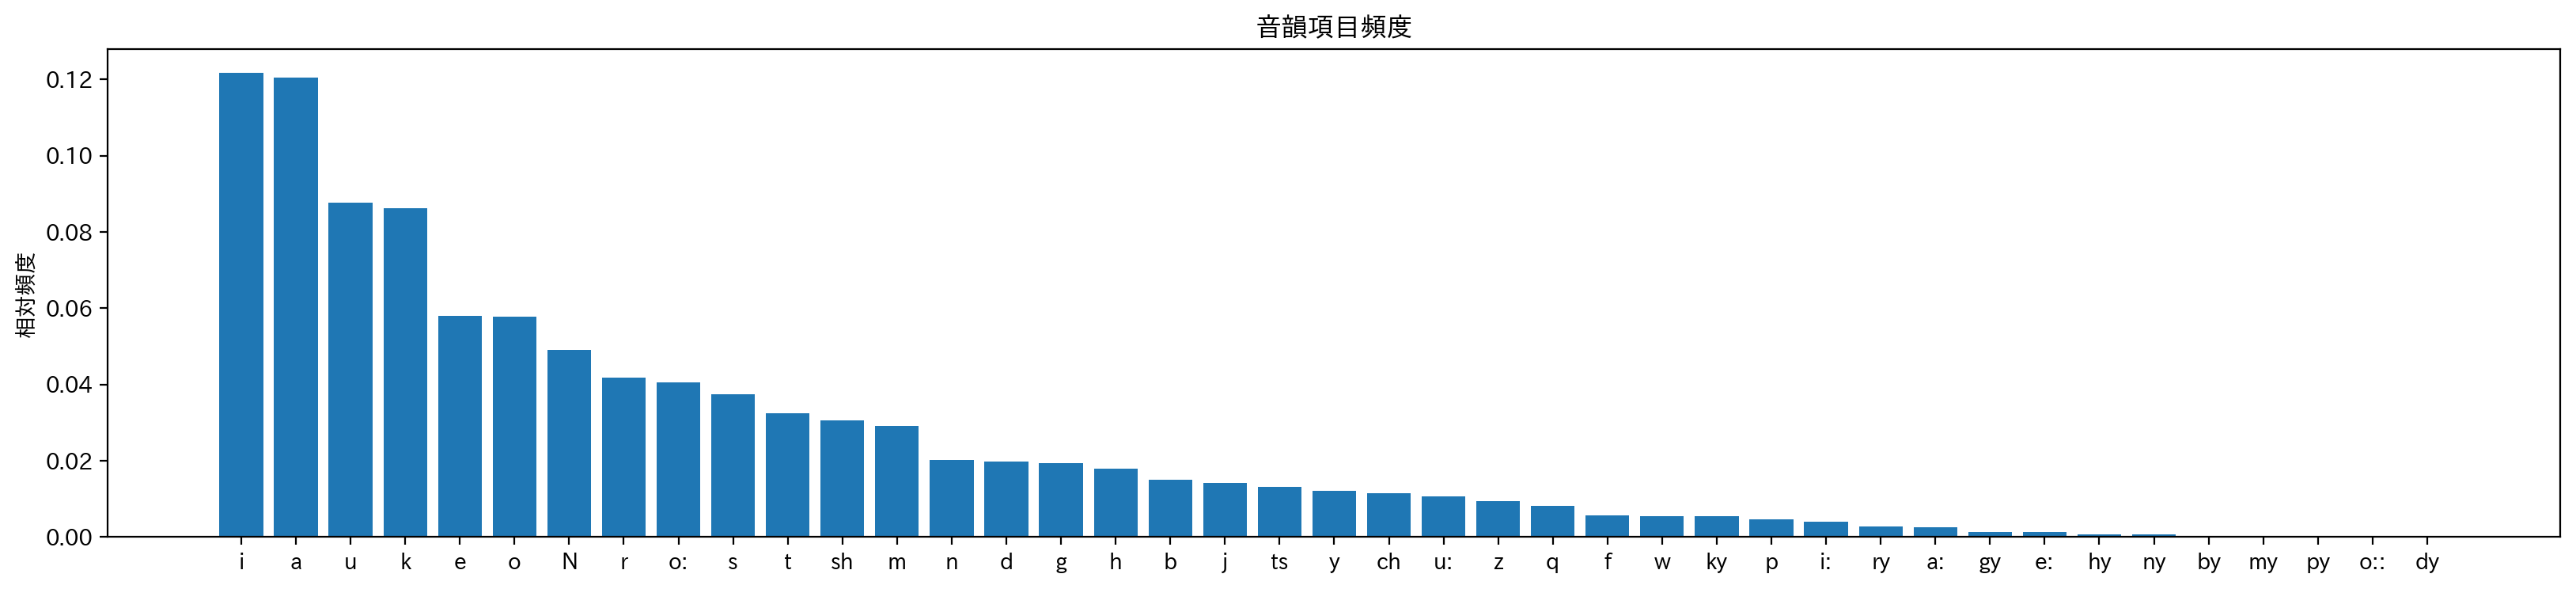

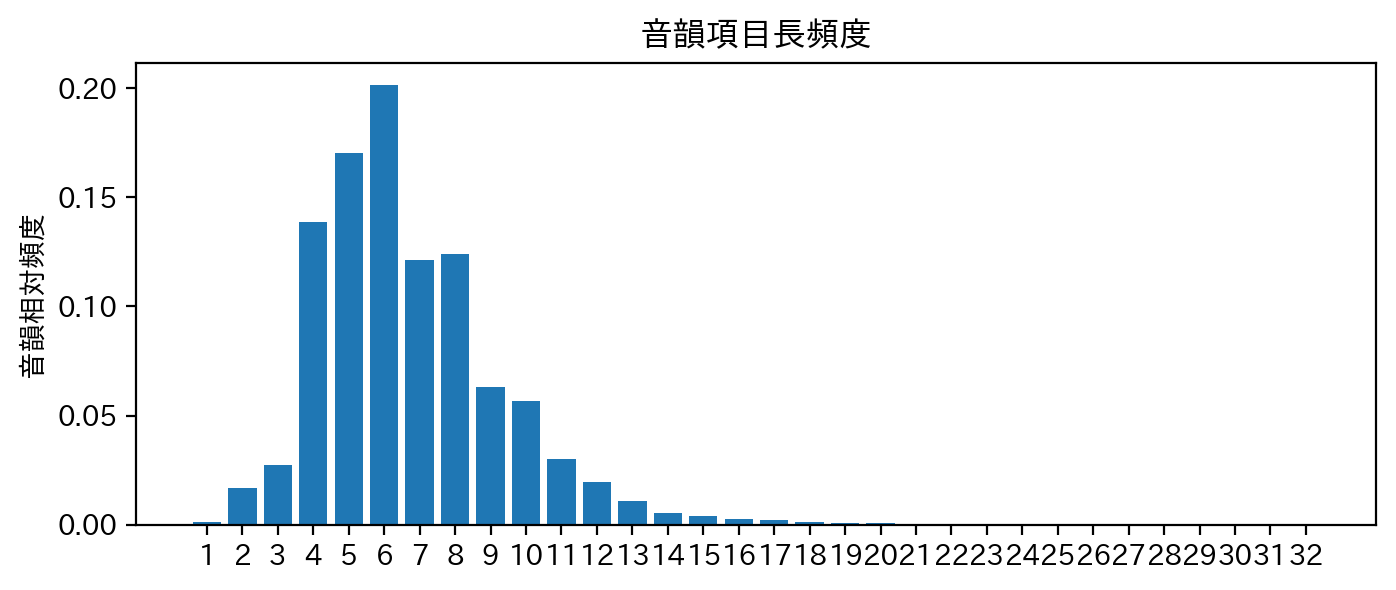

In [ ]:
from RAM import draw_word_char_histgram
draw_word_char_histgram(_dict=psylex71_ds.data_dict, key='phon', title='音韻', figsize2=(8,3))

## 0.4 psylex71_ds に存在する全単語を word2vec の埋め込みベクトル行列にする

In [ ]:
# psylex71_ds データから word2vec の埋め込みベクトル行列を得る
_words = [dct['orth'] for dct in psylex71_ds.data_dict.values()]

# gensim() の `vectors_for_all()` 関数を持ちて，望む語彙で構成される word2vec 単語埋め込みモデルを作成
w2v_psylex71 = w2v.vectors_for_all(_words)

# NaN データが入っている可能性がるので変換
w2v_psylex71.vectors = np.nan_to_num(w2v_psylex71.vectors)
print(f'w2v_psylex71.vectors.shape:{w2v_psylex71.vectors.shape}')
words = w2v_psylex71.index_to_key
#len(words)

w2v_psylex71.vectors.shape:(26877, 200)


## 0.5 psylex71 データセット中の単語における w2v の表示テスト

In [ ]:
Wrd = input('単語を入力してください:')
color = 'blue'
while (Wrd != ""):
    if Wrd in w2v_psylex71:
        Idx = w2v_psylex71.key_to_index[Wrd]
        print(f'入力単語 Wrd:{colored(Wrd, color, attrs=["bold"])},',
              f'対応する単語番号 Idx:{colored(Idx, color, attrs=["bold"])},',
              f'w2v_psylex71.get_index({Wrd}):{colored(w2v_psylex71.get_index(Wrd), color, attrs=["bold"])}')
    else:
        print(colored(f'{Wrd} という単語はありません。','red', attrs=['bold']))
    Wrd = input('単語を入力してください (終了するには改行のみを入力):')

単語を入力してください:山本
入力単語 Wrd:山本, 対応する単語番号 Idx:2011, w2v_psylex71.get_index(山本):2011
単語を入力してください (終了するには改行のみを入力):


## 0.6 書記素リストの作成

In [ ]:
import RAM

def _grapheme(words=words):
    """必要と思われる書記素リストを返す"""

    num_alpha='０１２３４５６７８９ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ'
    hira = 'あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをんぁぃぅぇっゃゅょゎ'+'ゔ'
    kata = 'アイウエオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモヤユヨラリルレロワヰヱヲン'+'ヴヷヸヹヺァィゥヵヶェォッャョュヮ'
    symbols='、。，．・：；？！゛゜´｀¨＾‾＿ヽヾゝゞ〃仝々〆〇ー—‐／＼〜‖｜…‥‘’“”（）〔〕［］｛｝〈〉《》「」『』【】＋−±×÷＝≠＜＞≦≧∞∴♂♀°′″℃¥＄¢£％＃＆＊＠§☆★○●◎◇' + '◆□■△▲▽▼※〒→←↑↓〓∈∋⊆⊇⊂⊃∪∩∧∨¬⇒⇔∀∃∠⊥⌒∂∇≡≒≪≫√∽∝∵∫∬Å‰♯♭♪†‡¶◯'
    #greek='ΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩαβγδεζηθικλμνξοπρστυφχψω'
    #rosian='АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    #digit_symbols='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽⑾⑿⒀⒁⒂⒃⒄⒅⒆⒇❶❷❸❹❺❻❼❽❾⒈⒉⒊⒋⒌⒍⒎⒏⒐'
    #alpha_symbols='ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫⅰⅱⅲⅳⅴⅵⅶⅷⅸⅹⅺⅻ⒜⒝⒞⒟⒠⒡⒢⒣⒤⒥⒦⒧⒨⒩⒪⒫⒬⒭⒮⒯⒰⒱⒲⒳⒴⒵'
    #units='㎜㎟㎝㎠㎤㎡㎥㎞㎢㎎㎏㏄㎖㎗ℓ㎘㎳㎲㎱㎰℉㏔㏋㎐㎅㎆㎇№㏍℡'
    #suits='♤♧♡♢♠♣♥♦〠☎〄☞☜☝☟⇆⇄⇅⇨⇦⇧⇩'
    #etc='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩ㍉㌔㌢㍍㌘㌧㌃㌶㍑㍗㌍㌦㌣㌫㍊㌻㎜㎝㎞㎎㎏㏄㎡㍻〝〟№㏍℡㊤㊥㊦㊧㊨㈱㈲㈹㍾㍽㍼≒≡∫∮∑√⊥∠∟⊿∵∩∪㊙'
    #etc2='㍉㌢㍍㌔㌖㌅㌳㍎㌃㌶㌘㌕㌧㍑㍊㌹㍗㌍㍂㌣㌦㌻㌫㌀㌞㌪㌱㍇㍾㍽㍼㍻㍿∮∟⊿〝'

    # RAM で作成済の常用漢字リストを用いて単漢字リストを作成
    # 平成 22 年の改定により常用漢字は 2136 文字ある
    chars_list = [ch for ch in num_alpha+hira+kata+symbols]+ RAM.chars_joyo().char_list
    not_chars_list = []
    for wrd in tqdm(words):
        for ch in wrd:
            if (ch not in chars_list) and (ch not in not_chars_list):
                not_chars_list.append(ch)
    not_chars_list = sorted(not_chars_list)
    grapheme = chars_list + not_chars_list
    # 上記の処理により grapheme には 2768 文字である。
    # これに特殊トークン 4 つ ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] を加えたリストを返す

    return ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + grapheme

grapheme = _grapheme()

  0%|          | 0/26877 [00:00<?, ?it/s]

## 0.7 データセット定義

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gensim

def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts


class psylex71_w2v_Dataset(Dataset):
    def __init__(self,
                 #direction='s2p',  # ['s2p', 'p2s']
                 source='seme',    # エンコーダ用 入力データ, ['orth', seme', 'phon'] のいずれか一つ
                 target='phon',    # デコーダ用 出力データ ,  ['orth', seme', 'phon'] のいずれか一つ
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                 #mecab_yomi=yomi,
                 grapheme:list=grapheme,
                ):

        super().__init__()
        self.ds_name = 'psylex71_'+source+"2"+target
        self.source, self.target = source, target

        self.w2v = w2v
        self.old_ds = old_ds
        #self.mecab_yomi = yomi         # 未知の単語が入力された場合 MeCab を使って読みをえるため
        self.grapheme = grapheme

        self.words = w2v.index_to_key  # gensim の KeyedVectors を利用して単語リストとする
        self.W = w2v.vectors

        # 訓令式に従った日本語ローマ字表記 `kurei.py` 参照
        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音



    def __getitem__(self, idx:int):
        wrd = self.words[idx]

        if self.source == 'phon':
            src = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.source == 'seme':
            src = torch.tensor(self.w2v.get_vector(idx))
        elif self.source == 'orth':
            src = torch.LongTensor(self.wrd2orth_ids(wrd))
        else:
            src = None

        if self.target == 'phon':
            tgt = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.target == 'seme':
            tgt = torch.tensor(self.w2v.get_vector(idx))
        elif self.target == 'orth':
            tgt = torch.LongTensor(self.wrd2orth_ids(wrd))
        else:
            tgt = None

        return src, tgt

    def __len__(self):
        return len(self.w2v)

    def getitem(self,
                idx:int):
        wrd = self.words[idx]
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        phon_ids = [self.phoneme.index(idx) for idx in _yomi]
        orth_ids = [self.grapheme.index(idx) for idx in wrd]
        return wrd, _yomi, phon_ids, orth_ids

    def source_ids2source(self, ids:list):

        if self.source == 'phon':
            return self.phon_ids2phn(ids)
        elif self.source == 'orth':
            return self.orth_ids2orth(ids)
        elif self.source == 'seme':
            wrd = self.getitem(ids)[0]
            return w2v.similar_by_word(wrd)
        else:
            return None


    def target_ids2target(self, ids:list):

        if self.target == 'phon':
            return self.phon_ids2phn(ids)
        elif self.target == 'orth':
            return self.orth_ids2orth(ids)
        elif self.target == 'seme':
            wrd = self.getitem(ids)[0]
            return w2v.similar_by_word(wrd)
        else:
            return None


    def wrd2orth_ids(self, wrd:str)->list:
        ids = [self.grapheme.index(ch) for ch in wrd]
        ids = [self.grapheme.index('<SOW>')] + ids + [self.grapheme.index('<EOW>')]
        #ids = [[self.grapheme.index('<SOW>')] + ids + [self.grapheme.index('<EOW>')]]
        return ids

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids

    def get_wrdidx_from_word(self, wrd:str):
        if wrd in self.words:
            wrd_idx = self.w2v.get_index(wrd)
        else:
            wrd_idx = -1
        return wrd_idx

    def wrd2emb(self, wrd:str)->np.ndarray:
        if wrd in self.words:
            return self.w2v.get_vector(wrd)
        else:
            return None

    def wrd2wrd_ids(self, wrd:str)->int:
        if wrd in self.words:
            return self.words.index(wrd)
        else:
            return None

    def orth_ids2orth(self,
                      ids:np.ndarray)->str:
    #def orth_ids2orth(self, ids:list)->str:
        ret = [self.grapheme[idx] for idx in ids]
        return ret

    def wrd_idx2wrd(self, idx:int)->str:
        if 0 <= idx and idx < len(self.words):
            return self.words[idx]
        else:
            return None

    def wrd2onehot(self, wrd:str)->np.ndarray:
        ret = np.zeros((self.W.shape[0],), dtype=np.int32)
        if wrd in self.words:
            ret[self.w2v.get_index(wrd)] = 1
            return ret
        else:
            return None

    def phon_ids2phn(self, ids:np.ndarray):
        ret = "".join([self.phoneme[idx] for idx in ids])
        return ret

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        else:
            _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


# 全部で 9 通りのデータセットを定義
psylex71_ds_o2o = psylex71_w2v_Dataset(source='orth', target='orth')
psylex71_ds_o2p = psylex71_w2v_Dataset(source='orth', target='phon')
psylex71_ds_o2s = psylex71_w2v_Dataset(source='orth', target='seme')

psylex71_ds_p2o = psylex71_w2v_Dataset(source='phon', target='orth')
psylex71_ds_p2p = psylex71_w2v_Dataset(source='phon', target='phon')
psylex71_ds_p2s = psylex71_w2v_Dataset(source='phon', target='seme')

psylex71_ds_s2o = psylex71_w2v_Dataset(source='seme', target='orth')
psylex71_ds_s2p = psylex71_w2v_Dataset(source='seme', target='phon')
psylex71_ds_s2s = psylex71_w2v_Dataset(source='seme', target='seme')

### 訓練データセットとテストデータへの分割。現時点で未使用

# モデルの定義

<div style="font-family:serif;font-size:14pt;color:purple;font-weight:900">

PyTorch RNN モデルの実装に対する注意メモ
    
* Encoder 側のデータと Decoder 側のデータそれぞれに対して Padding の処理を行う。
* Encoder 側のデータには Padding 値として `0` で埋める。
* Decoder 側のデータをモデルの forward で使う場合には、Padding 値は `0` を埋める。
* ただし，Decoder 側のデータを教師データとして使う場合には，Padding 値には -1 を用いて，埋めることに注意。
* `nn.Embedding()` のオプションに `padding_idx=O` を付け，`CrosEntropyLoss` のオプションに `ignore_index=-1` を付ける。

</div>


In [ ]:
# 全モデル共通使用するライブラリの輸入
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

## 0 共通のハイパーパラメータ宣言

In [ ]:
# Hyper parameters
n_hid = 128
n_layers = 1
bidirectional=False
batch_size = 1024

## 1 Seq2Seq model

In [ ]:
class Seq2Seq_wAtt(nn.Module):
    """ 注意つき符号化器‐復号化器モデル
    Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, arXiv:1409.0473
    """
    def __init__(self,
                 enc_vocab_size:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # Encoder 側の入力トークン id を多次元ベクトルに変換
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Decoder 側の入力トークン id を多次元ベクトルに変換
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Encoder LSTM 本体
        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # Decoder LSTM 本体
        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # 文脈ベクトルと出力ベクトルの合成を合成する層
        bi_fact = 2 if bidirectional else 1
        self.combine_layer = nn.Linear(bi_fact * 2 * n_hid, n_hid)

        # 最終出力層
        self.out_layer = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):

        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hnx, cnx) = self.encoder(enc_emb)

        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        # enc_out は (バッチサイズ，ソースの単語数，中間層の次元数)
        # ソース側 (enc_out) の各単語とターゲット側 (dec_out) の各単語との類似度を測定するため
        # 両テンソルの内積をとるため ソース側 (enc_out) の軸を入れ替え
        enc_outP = enc_out.permute(0,2,1)

        # sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数)
        sim = torch.bmm(dec_out, enc_outP)

        # sim の各次元のサイズを記録
        batch_size, dec_word_size, enc_word_size = sim.shape

        # sim に対して，ソフトマックスを行うため形状を変更
        simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

        # simP のソフトマックスを用いて注意の重み alpha を算出
        alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

        # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル c_t とする
        c_t = torch.bmm(alpha, enc_out)

        # torch.cat だから c_t と dec_out とで合成
        dec_out_ = torch.cat([c_t, dec_out], dim=2)
        dec_out_ = self.combine_layer(dec_out_)

        return self.out_layer(dec_out_)


# 以下確認作業
ds = psylex71_ds_o2p
o2p = Seq2Seq_wAtt(enc_vocab_size=len(ds.grapheme),
                   dec_vocab_size=len(ds.phoneme),
                   n_layers=n_layers,
                   bidirectional=bidirectional,
                   n_hid=n_hid).to(device)
print(o2p.eval())

Seq2Seq_wAtt(
  (encoder_emb): Embedding(2772, 128, padding_idx=0)
  (decoder_emb): Embedding(45, 128, padding_idx=0)
  (encoder): LSTM(128, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (combine_layer): Linear(in_features=256, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=45, bias=True)
)


## 2 Vec2Seq model

In [ ]:
class Vec2Seq(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(
            in_features=sem_dim,
            out_features=n_hid)
        self.decoder_emb = nn.Embedding(
            num_embeddings=dec_vocab_size,
            embedding_dim=n_hid,
            padding_idx=0)

        self.decoder = nn.LSTM(
            input_size=n_hid,
            hidden_size=n_hid,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional)

        # 最終出力層
        self.bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(self.bi_fact * n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        hnx = hnx.unsqueeze(0)
        cnx = cnx.unsqueeze(0)

        if self.bi_fact == 2:
            hnx = hnx.repeat(2)
            cnx = cnx.repeat(2)

        dec_emb = self.decoder_emb(dec_inp)

        batch_size = enc_inp.size(0)
        exp_hid_size = self.decoder.get_expected_hidden_size(enc_inp, batch_sizes=[batch_size])
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        return self.out_layer(dec_out)

# 以下確認作業
ds = psylex71_ds_s2p
s2p = Vec2Seq(
    sem_dim=ds.w2v.vector_size,
    dec_vocab_size=len(ds.phoneme),
    n_hid=n_hid,
    n_layers=n_layers,
    bidirectional=bidirectional).to(device)
print(s2p.eval())

Vec2Seq(
  (enc_transform_layer): Linear(in_features=200, out_features=128, bias=True)
  (decoder_emb): Embedding(45, 128, padding_idx=0)
  (decoder): LSTM(128, 128, batch_first=True)
  (out_layer): Linear(in_features=128, out_features=45, bias=True)
)


## 3 Seq2Vec model

In [ ]:
class Seq2Vec(nn.Module):
    """ 系列データを符号化器に与え，埋め込みデータ (ベクトル) を復号化するモデル
    """
    def __init__(
        self,
        sem_dim:int,
        enc_vocab_size:int,
        n_hid:int,
        n_layers:int=2,
        bidirectional:bool=False):

        super().__init__()
        self.encoder_emb = nn.Embedding(
            num_embeddings=enc_vocab_size,
            embedding_dim=n_hid,
            padding_idx=0)

        self.encoder = nn.LSTM(
            input_size=n_hid,
            hidden_size=n_hid,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional)

        bi_fact = 2 if bidirectional else 1

        self.encoder_out = nn.Linear(
            in_features=n_hid * bi_fact,
            out_features=enc_vocab_size)

        self.out_layer = nn.Linear(
            in_features=n_hid * bi_fact,
            out_features=sem_dim)

    def forward(self, enc_inp):
        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hid, cel) = self.encoder(enc_emb)
        _enc_out = self.encoder_out(enc_out)
        _sem = self.out_layer(hid)
        return _sem, _enc_out

# 以下確認作業
ds = psylex71_ds_o2s
o2s = Seq2Vec(sem_dim=ds.w2v.vector_size,
              enc_vocab_size=len(ds.grapheme),
              n_layers=n_layers,
              bidirectional=bidirectional,
              n_hid=n_hid).to(device)
print(o2s.eval())

Seq2Vec(
  (encoder_emb): Embedding(2772, 128, padding_idx=0)
  (encoder): LSTM(128, 128, batch_first=True)
  (encoder_out): Linear(in_features=128, out_features=2772, bias=True)
  (out_layer): Linear(in_features=128, out_features=200, bias=True)
)


## 4 Vec2Vec model

In [ ]:
class Vec2Vec(nn.Module):
    """ ベクトル埋め込み表現をベクトル埋め込み表現へと変換
    """
    def __init__(self,
                 sem_dim:int,
                 n_hid:int):

        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(sem_dim, n_hid),
            nn.ReLU(),
            nn.Linear(n_hid, n_hid),
            nn.ReLU(),
            nn.Linear(n_hid, sem_dim),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 以下確認作業
ds = psylex71_ds_s2s
s2s = Vec2Vec(sem_dim=ds.w2v.vector_size,
              n_hid=n_hid).to(device)
print(s2s.eval())

## 5 各モデルの宣言

In [ ]:
print(colored('# 1 写字モデル o2o', color='blue', attrs=["bold"]))
ds = psylex71_ds_o2o
o2o = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.grapheme),
    dec_vocab_size=len(ds.grapheme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(o2o.eval())

print(colored('# 2 o2p 音読モデル意味関与なし', color='blue', attrs=["bold"]))
ds = psylex71_ds_o2p
o2p = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.grapheme),
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(o2p.eval())

print(colored('# 3 o2s 印字理解モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_o2s
o2s = Seq2Vec(
    enc_vocab_size=len(ds.grapheme),
    sem_dim=ds.w2v.vector_size,
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(o2s.eval())

print(colored('# 4 p2o 聞き書き ディクテーションモデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_p2o
p2o = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.phoneme),
    dec_vocab_size=len(ds.grapheme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(p2o.eval())

print(colored('# 5 p2p 復唱モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_p2p
p2p = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.phoneme),
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(p2p.eval())

print(colored('# 6 p2s 聴理解モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_p2s
p2s = Seq2Vec(
    enc_vocab_size=len(ds.phoneme),
    sem_dim=ds.w2v.vector_size,
    n_hid=n_hid, n_layers=n_layers, bidirectional=bidirectional).to(device)
print(p2s.eval())

print(colored('# 7 s2o 書字モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_s2o
s2o = Vec2Seq(
    sem_dim=ds.w2v.vector_size,
    dec_vocab_size=len(ds.grapheme),
    n_hid=n_hid, n_layers=n_layers, bidirectional=bidirectional).to(device)
print(s2o.eval())

print(colored('# 8 s2p 発話モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_s2p
s2p = Vec2Seq(
    sem_dim=ds.w2v.vector_size,
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(s2p.eval())

print(colored('# 9 s2s 意味理解モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_s2s
s2s = Vec2Vec(
    sem_dim=ds.w2v.vector_size,
    n_hid=n_hid).to(device)
print(s2s.eval())

# 2 訓練手続きの定義

## `fit_seq2seq()`

In [ ]:
def fit_seq2seq(
    model:torch.nn.modules.module.Module=o2p,
    epochs:int=10,
    ds:Dataset=psylex71_ds_o2p,
    batch_size=batch_size,
    collate_fn=_collate_fn,
    #dataloader:torch.utils.data.dataloader.DataLoader=dl_o2p,
    optimizer:torch.optim=None,
    criterion:torch.nn.modules.loss=nn.CrossEntropyLoss(ignore_index=-1),
    interval:int=None,
    isPrint:bool=False,
    losses:list=None,
    isDraw:bool=True,):
    """ Seq2seq の訓練に用いる関数"""

    start_time = time.time()   # 開始時刻の保存

    dataloader = DataLoader(
        dataset=ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn)


    if losses == None:
        losses = []

    model.train()

    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    if interval == None:
        interval = int(ds.__len__()/batch_size) >> 2

    for epoch in range(epochs):
        i = 0
        for _inp, _tch in dataloader:
            enc_inp = pad_sequence(_inp, batch_first=True).to(device)
            dec_inp = pad_sequence(_tch, batch_first=True).to(device)
            tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
            out = model(enc_inp, dec_inp)
            loss = criterion(out[0], tch[0])
            for h in range(1,len(tch)):
                loss += criterion(out[h], tch[h])
            losses.append(loss.item()/len(_inp))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i += 1
            if (i % interval) == 0:
                print(f'epoch:{epoch+1:2d}',
                      f'batch:{i:2d}',
                      f'loss:{loss.item()/batch_size:.5f}')

    end_time = time.time()
    total_time = end_time - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))

    if isDraw:
        plt.plot(losses)
        plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
        plt.show()

    return {'Training time':total_time_str,
            'losses': losses,
            'optimizer': optimizer,
            'time': total_time
           }

fit_seq2seq(epochs=1, model=o2p, ds=psylex71_ds_o2p); # 音読モデル
fit_seq2seq(epochs=1, model=p2p, ds=psylex71_ds_p2p); # 復唱モデル
fit_seq2seq(epochs=1, model=p2o, ds=psylex71_ds_p2o); # ディクテーションモデル
fit_seq2seq(epochs=1, model=o2o, ds=psylex71_ds_o2o); # 写字モデル

## `eval_seq2seq()`

In [ ]:
def eval_seq2seq(
    model:torch.nn.modules.module.Module=o2p,
    ds:Dataset=psylex71_ds_o2p,
    isPrint:bool=False,
    errors:list=None):

    model.eval()
    if errors == None:
        errors=[]

    for N in tqdm(range(ds.__len__())):
        x, y = ds.__getitem__(N)
        enc_inp, dec_inp = x.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        grand_truth = y.detach().numpy()[1:-1]
        y_hat = model(enc_inp, dec_inp).to('cpu')
        y_hat = np.argmax(y_hat.squeeze(0).detach().numpy(), axis=1)[1:-1]

        if len(y_hat) == len(grand_truth):
            n_correct = np.array((y_hat == grand_truth).sum())
            isOK = n_correct == len(grand_truth)
        else:
            isOK = False

        if not isOK:
            wrd = ds.getitem(N)[0]
            _out = ds.target_ids2target(y_hat)
            errors.append((N, wrd, _out,y_hat))
            if isPrint:
                color = 'grey' if isOK else 'red'
                wrd = ds.getitem(N)[0]
                print(colored(f'{N:05d}', color),
                      colored(wrd, color='grey'), # , attrs=["bold"]),
                      colored(y_hat,color,attrs=["bold"]),
                      colored(ds.target_ids2target(y_hat), color, attrs=["bold"]),
                      f'<-{ds.target_ids2target(grand_truth)}')

    cr = len(errors) / N
    return {'エラー':errors,
            '正解率': (1.-cr) * 100}

In [ ]:
_ = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)
#result_o2p = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)


In [ ]:
_

In [ ]:
%%time
# 読字モデル
errors_o2p = fit_seq2seq(epochs=10, model=o2p, ds=psylex71_ds_o2p)
errors = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)

# 復唱モデル
errors_p2p = fit_seq2seq(epochs=10, model=p2p, ds=psylex71_ds_p2p)
result_p2p = eval_seq2seq(model=p2p, ds=psylex71_ds_p2p)

# 書き取りディクテーションモデル
errors_p2o = fit_seq2seq(epochs=10, model=p2o, ds=psylex71_ds_p2o)
result_p2o = eval_seq2seq(model=p2o, ds=psylex71_ds_p2o)

# 写字モデル
errors_o2o = fit_seq2seq(epochs=10, model=o2o, ds=psylex71_ds_o2o)
result_o2o = eval_seq2seq(model=o2o, ds=psylex71_ds_o2o)

In [ ]:
# 読字モデル
print(errors_o2p)
print(result_o2p)

# 復唱モデル
print(errors_p2p)
print(result_p2p)

# 書き取りディクテーションモデル
print(errors_p2o)
print(result_p2o)

# 写字モデル
print(errors_o2o)
print(result_o2o)

## o2p だけもう一度

In [ ]:
errors_o2p = fit_seq2seq(epochs=10, model=o2p, ds=psylex71_ds_o2p)
errors = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)
print(errors)

## o2p だけ結果をファイルに保存

In [ ]:
o2p.eval()
fname_saved = '2023_1117o2p_h128.pt'
torch.save(o2p.state_dict(), fname_saved)
state_dict = torch.load(fname_saved)

ds = psylex71_ds_o2p
_o2p = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.grapheme),
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(_o2p.eval())

_o2p.load_state_dict(state_dict)
errors = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)
print(errors['正解率'])

## `fit_vec2sec()` の定義
実際には `fit_seq2seq()` を用いるため何もしない。

## `eval_vec2sec()` は `eval_seq2seq()` と同じ

## `fit_seq2vec()` の定義

In [ ]:
def fit_seq2vec(
    model:torch.nn.modules.module.Module=o2p,
    epochs:int=10,
    ds:Dataset=psylex71_ds_o2s,
    batch_size=batch_size,
    collate_fn=_collate_fn,
    #dataloader:torch.utils.data.dataloader.DataLoader=dl_o2s,
    optimizer:torch.optim=None,
    lr:float=0.001,
    criterion_dec:torch.nn.modules.loss=nn.MSELoss(),
    criterion_enc:torch.nn.modules.loss=nn.CrossEntropyLoss(ignore_index=-1),
    interval:int=None,
    isPrint:bool=False,
    losses:list=None,
    isDraw:bool=True,):
    """ Seq2vec の訓練に用いる関数"""

    start_time = time.time()   # 開始時刻の保存

    dataloader = DataLoader(
        dataset=ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn)

    if losses == None:
        losses = []

    model.train()

    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    criterion_dec = nn.MSELoss()
    criterion_enc = nn.CrossEntropyLoss(ignore_index=-1)
    #criterion_enc = nn.CrossEntropyLoss(ignore_index=0)

    if interval == None:
        interval = int(ds.__len__()/batch_size) >> 2

    for epoch in range(epochs):
        i = 0
        for _inp, _tch in dataloader:
            enc_inp = pad_sequence(_inp, batch_first=True).to(device)
            tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
            out, enc_out = model(enc_inp)

            out = out.squeeze(0)
            loss = criterion_dec(out, tch)
            for _x, _y in zip(enc_out[:,:-1,:], enc_inp[:,1:]):
                loss += criterion_enc(_x, _y)
            losses.append(loss.item()/len(_inp))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            i += 1
            if (i % interval) == 0:
                print(f'epoch:{epoch+1:2d}',
                      f'batch:{i:2d}',
                      f'loss:{loss.item()/batch_size:.5f}')

    end_time = time.time()
    total_time = end_time - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))

    if isDraw:
        plt.plot(losses)
        plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
        plt.show()

    return {'Training time': total_time_str,
            'losses': losses,
            'optimizer': optimizer,
            'time': total_time }

result = fit_seq2vec(epochs=10, model=p2s, lr=0.0001, ds=psylex71_ds_p2s) # , dataloader=dl_p2s); # 聴理解モデル
#fit_seq2vec(epochs=50, model=o2s, lr=0.0001, ds=psylex71_ds_o2s, dataloader=dl_o2s); # 印字理解モデル
#fit_seq2vec(epochs=20, model=o2s, lr=0.00001, ds=psylex71_ds_o2s, dataloader=dl_o2s); # 印字理解モデル
#fit_seq2vec(epochs=20, model=o2s, lr=0.0001, ds=psylex71_ds_o2s); # 印字理解モデル

## `eval_seq2vec()` の定義 ーーー

In [ ]:
import scipy

isPrint = True

errors = []
model = o2s
model = p2s
model.eval()

ds = psylex71_ds_o2s
ds = psylex71_ds_p2s

top_N = 3  # 上位候補のうち N 位まで表示させる
for N in tqdm(range(ds.__len__()>>8)):
    _inp, _tch  = ds.__getitem__(N)

    # dataset から入力データと教師データを得る
    enc_inp, dec_inp = _inp.to(device), _tch.to(device)

    # モデルに入力して出力を取得する
    out_vec, _ = model(enc_inp) # .to('cpu')
    out_vec = out_vec.detach().squeeze(0).numpy()

    grand_truth = ds.getitem(N)  # 正解を得る
    tgt_wrd = grand_truth[0]     # 正解単語を得る

    # 正解単語の意味的類似語を得る。最後に [1:] しているのは自分自身は不要だから
    tgt_neighbors = ds.w2v.most_similar(_tch.detach().numpy())[1:]

    # モデル出力から得られた単語ベクトルの意味的類似語を得る
    out_neighbors = ds.w2v.similar_by_vector(out_vec)
    #out_neighbors = ds.w2v.similar_by_vector(out_vec.detach().squeeze(0).numpy())
    out_neighbors = ds.w2v.most_similar(out_vec)
    #out_neighbors = ds.w2v.most_similar(out_vec.squeeze(0).detach().numpy())
    #print(out_neighbors_)

    # 正解単語の埋め込みベクトルを得る
    tgt_vec = ds.w2v.get_vector(tgt_wrd)
    tch_vec = _tch.detach().squeeze(0).numpy()

    w2v_cos = ds.w2v.cosine_similarities(out_vec,[tch_vec])
    spy_euc = scipy.spatial.distance.euclidean(out_vec, tch_vec)

    print(f'{N:5d} '
          f'正解:{tgt_wrd},', end=" ")
    print('出力:', end="")
    for _ in out_neighbors[:top_N]:
        print(colored(f'{_[0]}:{_[1]:.3f}',color='blue',attrs=['bold']), end=" ")

    print('<- 正解:', end="")
    for _ in tgt_neighbors[:top_N]:
        print(f'{_[0]}:{_[1]:.3f}', end=" ")
    print(f'出力と正解との距離 cos_sim: {w2v_cos[0]:.3f},'
          f'euc_dist: {spy_euc:.3f}',
         )
    #print("")
    #sys.exit()

#cr = len(errors) / N
#cr = len(errors) / _psylex71_ds.__len__()
#print(f'総エラー数:{len(errors)}',
#      f'正解率:{(1.-cr)*100:.3f}%')

# 3 各モデルの訓練と評価



## 3.1 印字音読モデル o2p 書記から音韻

In [ ]:
# 音読モデルの訓練
# 音読モデル
errors_o2p = fit_seq2seq(epochs=10, model=o2p, dataloader=dl_o2p)

# 音読モデルの結果評価
result_o2p = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p, isPrint=True)

## 3.2 写字モデル o2o

In [ ]:
# モデルの訓練
errors_o2o = fit_seq2seq(epochs=1o, model=o2o, dataloader=dl_o2o)

# モデルの結果評価
result_o2o = eval_seq2seq(model=o2p, ds=psylex71_ds_o2o, isPrint=True)

## 3.3 p2o 聞き書き ディクテーションモデル

In [ ]:
# モデルの訓練
errors_p2o = fit_seq2seq(epochs=10, model=p2o, dataloader=dl_p2o);

# モデルの結果評価
result_p2o = eval_seq2seq(model=p2o, ds=psylex71_ds_p2o, isPrint=True)

## 3.4 p2p 復唱モデル

In [ ]:
# モデルの訓練
errors_p2p = fit_seq2seq(epochs=10, model=p2p, ds=psylex71_ds_p2p)

# モデルの結果評価
result_p2p = eval_seq2seq(model=p2p, ds=psylex71_ds_p2p, isPrint=True)

## 3.5 o2s 黙読モデル

In [ ]:
# モデルの訓練
errors_o2s = fit_seq2vec(epochs=10, model=o2s, ds=psylex71_ds_o2s)

# モデルの結果評価
result_o2s = eval_seq2vec(model=o2s, ds=psylex71_ds_o2s, isPrint=True)

## 3.6 p2s 聞き取りモデル

In [ ]:
# モデルの訓練
errors_p2s = fit_seq2vec(epochs=10, model=p2s, ds=psylex71_ds_p2s)

# モデルの結果評価
eval_seq2vec(model=p2s, ds=psylex71_ds_p2s, isPrint=True)

## 3.7 s2o 書き出しモデル

In [ ]:
errors_s2o = fit_seq2seq(epochs=15, model=s2o, ds=psylex71_ds_s2o)
result_s2o = eval_seq2seq(model=s2o, ds=psylex71_ds_s2o)

## 3.8 s2p 発話モデル

In [ ]:
errors_s2p = fit_seq2seq(epochs=15, model=s2p, ds=psylex71_ds_s2p)
result_s2p = eval_seq2seq(model=s2p, ds=psylex71_ds_s2p)

## 3.9 s2s 自発的納得モデル

In [ ]:
start_time = time.time()   # 開始時刻の保存

dataloader = dl_o2p

model = o2p
# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ
model.train()
interval = int(ds.__len__()/batch_size) >> 2
losses = []

dataloader = dl_o2p
epochs = 5
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:

        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)

        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')


end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

In [ ]:
errors_s2p = fit_seq2seq(epochs=15, model=s2p, ds=psylex71_ds_s2p)
result_s2p = eval_seq2seq(model=s2p, ds=psylex71_ds_s2p)

errors_s2o = fit_seq2seq(epochs=15, model=s2o, ds=psylex71_ds_s2o)
result_s2o = eval_seq2seq(model=s2o, ds=psylex71_ds_s2o)

# 3 書記+意味->音韻 os2p モデル

## 3.1 データセットの定義

### ***<font style="color:teal">書記符号化器から書記埋め込みベクトルを取り出す</font>***

In [ ]:
orth_emb_vec = []
_o2p.eval()
ds = psylex71_ds_o2p
for N in range(ds.__len__()):
    inp, tch = ds.__getitem__(N)
    enc_emb = _o2p.encoder_emb(inp)
    enc_out, (hnx, cnx) = o2p.encoder(enc_emb)
    orth_emb_vec.append(hnx.detach().squeeze(0).numpy())
orth_emb = np.array(orth_emb_vec)
print(f'orth_emb.shape:{orth_emb.shape}')
print(f'len(grapheme):{len(grapheme)}')

In [ ]:
class OS2P_Dataset(Dataset):
    def __init__(self,
                 #phoneme:list=phoneme,
                 grapheme:list=grapheme,
                 orth_vecs:np.ndarray=orth_emb,
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 seme_vecs:np.array=w2v_psylex71.vectors,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                )->None:
        self.ds_name = 'orth_seme_2_phon_dataset'
        self.w2v = w2v

        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音

        self.orth_vecs = orth_vecs
        self.seme_vecs = seme_vecs
        self.words = w2v.index_to_key
        self.old_ds = old_ds
        wrd2phn = {}
        for wrd in self.words:
            yomi = self.wrd2yomi(wrd)
            phon = kunrei(yomi).split(' ')
            wrd2phn[wrd] = phon
        self.wrd2phn = wrd2phn

    def __len__(self):
        return len(self.words) # 936

    def __getitem__(self, idx:int)->list:
        orth_vec = torch.tensor(self.orth_vecs[idx]).to(device)
        seme_vec = torch.tensor(self.seme_vecs[idx]).to(device)
        inp = torch.cat((orth_vec, seme_vec)).to(device)

        wrd = self.words[idx]
        phn_ids = self.wrd2phon_ids(wrd)
        tch = phn_ids
        # phon_ids = self.wrd2phn[wrd]
        # tch = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        # print(f'wrd:{wrd}, tch:{tch}, type(tch):{type(tch)}')
        # sys.exit()
        tch = torch.LongTensor(tch).to(device)
        return inp, tch

    def getitem(self, idx:int):
        wrd = self.words[idx]
        phon = self.wrd2phn[wrd]
        phon_ids = [self.phoneme.index(p) for p in phon]
        phon_ids = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        return wrd, phon, phon_ids

    def phon_ids2phon(self, ids:list)->list:
        return [self.phoneme[idx] for idx in ids]

    def target_ids2target(self, ids:list):
        return self.phon_ids2phon(ids)

    def phon_ids2phon(self, ids:list)->list:
        return [self.phoneme[idx] for idx in ids]

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        # else:
        #     _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


os2p_ds = OS2P_Dataset()
#print(os2p_ds.__len__())
Ns = np.random.permutation(os2p_ds.__len__())
for N in Ns[:3]:
    inp, tch = os2p_ds.__getitem__(N)
    print(f'inp.size():{inp.size()}')
    print(f'n_hid:{n_hid}')
    print(f'tch:{tch}')
    print(f'os2p_ds.phon_ids2phon(tch.detach().numpy()):{os2p_ds.phon_ids2phon(tch.detach().numpy())}')
    print(f'os2p_ds.words[0]:{os2p_ds.words[N]}')

In [ ]:
import copy

class Vec2Seq(nn.Module):
    def __init__(self,
                 inp_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 decoder:nn.Module=o2p.decoder,
                 bidirectional:bool=False):
        super().__init__()

        self.decoder = copy.deepcopy(decoder)

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(
            in_features=inp_dim,
            out_features=n_hid)
        self.decoder_emb = nn.Embedding(
            num_embeddings=dec_vocab_size,
            embedding_dim=n_hid,
            padding_idx=0)

        self.decoder = nn.LSTM(
            input_size=n_hid,
            hidden_size=n_hid,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional)

        # 最終出力層
        self.bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(self.bi_fact * n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        hnx = hnx.unsqueeze(0)
        cnx = cnx.unsqueeze(0)

        if self.bi_fact == 2:
            hnx = hnx.repeat(2)
            cnx = cnx.repeat(2)

        dec_emb = self.decoder_emb(dec_inp)

        batch_size = enc_inp.size(0)
        exp_hid_size = self.decoder.get_expected_hidden_size(enc_inp, batch_sizes=[batch_size])
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        return self.out_layer(dec_out)

# 以下確認作業
ds = os2p_ds
os2p = Vec2Seq(
    inp_dim=ds.w2v.vector_size+n_hid,
    dec_vocab_size=len(ds.phoneme),
    n_hid=n_hid,
    n_layers=n_layers,
    bidirectional=bidirectional).to(device)
print(os2p.eval())

res = fit_seq2seq(epochs=1, model=os2p, ds=os2p_ds, interval=8)

## 2.3 モデルの訓練

In [ ]:
res = fit_seq2seq(epochs=10, model=os2p, ds=os2p_ds, interval=8)

## 3.2 訓練結果の評価

In [ ]:
os2p_errors = eval_seq2seq(model=os2p, ds=os2p_ds)

In [ ]:
os2p_errors.keys()
for err in os2p_errors['エラー']:
    print(err)
print(f"正解率: {os2p_errors['正解率']:.3f} %")


In [ ]:
print(os2p.eval())
state_dict = os2p.state_dict()
fname = '2023_1117os2ps_hid128.pt'
torch.save(state_dict, fname)

os2p_saved = Vec2Seq(
    inp_dim=ds.w2v.vector_size+n_hid,
    dec_vocab_size=len(ds.phoneme),
    n_hid=n_hid,
    n_layers=n_layers,
    bidirectional=bidirectional).to(device)
os2p_saved.load_state_dict(state_dict)
os2p_saved_errors = eval_seq2seq(model=os2p_saved, ds=os2p_ds)
#os2p_saved_errors.keys()
for err in os2p_saved_errors['エラー']:
    print(err)
print(f"正解率: {os2p_saved_errors['正解率']:.3f} %")


## 3.1 データセットの定義

In [ ]:
model.eval()
#enc_emb.dtype
#enc_inp

N = 0
x, y = ds.__getitem__(N)
enc_inp = torch.from_numpy(np.array(x)).to(device).unsqueeze(0)
enc_emb = model.enc_transform_layer(enc_inp)
hnx, cnx = enc_emb.clone(), enc_emb.clone()
dec_inp = y.to(device)
dec_emb = model.decoder_emb(dec_inp)

In [ ]:
# model.eval()
# isPrint = False
# errors = []
# for N in tqdm(range(_psylex71_ds.__len__())):
# #for N in np.random.permutation(_psylex71_ds.__len__())[:100]:
#     x, y = _psylex71_ds.__getitem__(N)
#     enc_inp = torch.from_numpy(np.array(x)).to(device).unsqueeze(0)
#     enc_emb = model.out_layer(enc_inp)
#     hnx, cnx = enc_emb.clone(), enc_emb.clone()
#     dec_inp = y.to(device)
#     dec_emb = model.decoder_emb(dec_inp).to(device)
#     dec_out, (hny, cny) = model.decoder(dec_emb,(hnx, cnx))
#     dec_out = model.out_layer(dec_out).to('cpu')
#     y_ids = np.argmax(dec_out.detach().numpy(),axis=1)

#     n_correct = np.array((y_ids[1:-1] == _psylex71_ds.getitem(N)[2]).sum())
#     isOK = n_correct == len(_psylex71_ds.getitem(N)[2])
#     color = 'grey' if isOK else 'red'

#     if not isOK:
#         errors.append((N,y_ids))
#         if isPrint:
#             print(colored((f'{N:05d}', #y_ids,
#                            "".join(p for p in _psylex71_ds.phon_ids2phn(y_ids[1:-1]))),color,attrs=["bold"]), end=" ")
#             print(_psylex71_ds.getitem(N))

# cr = len(errors) / _psylex71_ds.__len__()
# print(f'総エラー数:{len(errors)}',
#       f'正解率:{(1.-cr)*100:.3f}')


# 4 聞き取り理解モデル p2s 音韻から意味

In [ ]:
help(_psylex71_ds.w2v.similar_by_vector)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_s2s(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 n_hid:int):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=sem_dim,
                                      out_features=n_hid)
        self.out_layer = nn.Linear(in_features=n_hid,
                                   out_features=sem_dim)

    def forward(self, enc_inp):
        hid = self.hidden_layer(enc_inp)
        out = self.out_layer(hid)
        return out


n_hid = 128
#model = EncDec_s2s(sem_dim=_psylex71_ds.w2v.vector_size,
#                   n_hid=n_hid)

model = nn.Sequential(
    nn.Linear(_psylex71_ds.w2v.vector_size, n_hid),
    nn.ReLU(),
    nn.Linear(n_hid, n_hid),
    nn.ReLU(),
    nn.Linear(n_hid, _psylex71_ds.w2v.vector_size),
    nn.Tanh()
)


start_time = time.time()
epochs = 20
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

model.train()
interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for x, y in dataloader:
        tch = torch.tensor([_x.detach().numpy() for _x in x]).to(device)

        out = model(tch)
        loss = criterion_dec(out, tch)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item():.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()


# 5 聞き取り書き取りモデル p2o 音韻から書記

In [ ]:
start_time = time.time()   # 開始時刻の保存

model = p2o
model.train()

#epochs = 10
epochs = 5

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ

ds = _psylex71_ds_p2o
interval = int(ds.__len__()/batch_size) >> 2
dataloader = dl_p2o
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch+1:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

# 6 写字モデル o2o 書記から書記

In [ ]:
start_time = time.time()   # 開始時刻の保存

model = o2o
model.train()

#epochs = 10
epochs = 2

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ

ds = _psylex71_ds_o2o
interval = int(ds.__len__()/batch_size) >> 2
dataloader = dl_o2o
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch+1:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

# 7 内部で納得モデル s2s 意味から意味

In [ ]:
model = s2s
model.eval()

model.train()

#epochs = 10
epochs = 2

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ

ds = _psylex71_ds_o2o
interval = int(ds.__len__()/batch_size) >> 2
dataloader = dl_o2o
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch+1:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

In [ ]:
start_time = time.time()   # 開始時刻の保存

model = s2s
model.train()

#epochs = 10
epochs = 2

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ

ds = _psylex71_ds_s2s
interval = int(ds.__len__()/batch_size) >> 2
dataloader = dl_s2s
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch+1:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

# 8 書き出しモデル s2o 意味から書記へ

In [ ]:
start_time = time.time()   # 開始時刻の保存

model = s2o
model.train()

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ
ds = _psylex71_ds_s2o
interval = int(ds.__len__()/batch_size) >> 2
dataloader = dl_s2o
losses = []
#epochs = 10
epochs = 2

for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch+1:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

# 9 黙読モデル o2s 書記から意味へ

In [ ]:
start_time = time.time()

model = o2s
model.train()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion_dec = nn.MSELoss()
criterion_enc = nn.CrossEntropyLoss()

ds = psylex71_ds_o2s
dataloader = dl_o2s
interval = int(ds.__len__()/batch_size) >> 2
epochs = 5
losses = []
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:
        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        tch = torch.tensor([x.detach().numpy() for x in _tch]).to(device)
        out, enc_out = model(enc_inp)
        loss = criterion_dec(out, tch)
        for _x, _y in zip(enc_out[:,:-1], enc_inp[:,1:]):
            loss += criterion_enc(_x, _y)
        losses.append(loss.item()/len(_inp))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(_inp):.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

In [ ]:
start_time = time.time()   # 開始時刻の保存

model = o2s
ds = psylex71_ds_o2s
dataloader = dl_o2s

optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion_dec = nn.MSELoss()
criterion_enc = nn.CrossEntropyLoss(ignore_index=-1)

#epochs = 10
epochs = 2

# 訓練ループ
losses = []
interval = int(ds.__len__()/batch_size) >> 2
model.train()
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:

        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        #tch = torch.tensor([x.detach().numpy() for x in _tch]).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
        out, enc_out = model(enc_inp)
        loss = criterion_dec(out, tch)
        for _x, _y in zip(enc_out[:,:-1], enc_inp[:,1:]):

            print(_x.size(), _y.size())
            loss += criterion_enc(_x, _y)
            sys.exit()
        losses.append(loss.item()/len(_inp))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(_inp):.3f}')

        #dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        #out = model(enc_inp)  # , dec_inp)
        #loss = criterion(out[0], tch[0])
        #for h in range(1,len(tch)):
        #    loss += criterion(out[h], tch[h])



end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

# 10 書記から意味を解して音韻

# 7) 書記から意味を介さず音韻
# 8) 6 と 7 の比較

In [ ]:
#help(RAM.chars_joyo)
j = RAM.chars_joyo()
#print(dir(j))
ch_list = ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + j.char_list
not_chlist = []
for N in range(_psylex71_ds.__len__()):
    wrd = _psylex71_ds.getitem(N)[0]
    for ch in wrd:
        if (ch not in ch_list) and (ch not in not_chlist):
            not_chlist.append(ch)
print(len(not_chlist))

In [ ]:
print(sorted(not_chlist))

In [ ]:
#help(RAM.chars_joyo)
print(len(grapheme))
#print(grapheme)
#print(chars_list + not_chars_list)

In [ ]:
# # 訓練関数の定義
# def fit_seq2vec(
#     model:torch.nn.modules.module.Module=o2p,
#     epochs:int=10,
#     ds:Dataset=psylex71_ds_o2s,
#     dataloader:torch.utils.data.dataloader.DataLoader=dl_o2s,
#     optimizer:torch.optim=None,
#     lr:float=0.001,
#     criterion_dec:torch.nn.modules.loss=nn.MSELoss(),
#     criterion_enc:torch.nn.modules.loss=nn.CrossEntropyLoss(ignore_index=-1),
#     interval:int=None,
#     isPrint:bool=False,
#     losses:list=None,
#     isDraw:bool=True,):
#     """ Seq2vec の訓練に用いる関数"""

#     start_time = time.time()   # 開始時刻の保存

#     if losses == None:
#         losses = []

#     model.train()

#     if optimizer == None:
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#     criterion_dec = nn.MSELoss()
#     criterion_enc = nn.CrossEntropyLoss(ignore_index=-1)
#     #criterion_enc = nn.CrossEntropyLoss(ignore_index=0)

#     if interval == None:
#         interval = int(ds.__len__()/batch_size) >> 2

#     for epoch in range(epochs):
#         i = 0
#         for _inp, _tch in dataloader:
#             enc_inp = pad_sequence(_inp, batch_first=True).to(device)
#             tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
#             out, enc_out = model(enc_inp)

#             out = out.squeeze(0)
#             loss = criterion_dec(out, tch)
#             for _x, _y in zip(enc_out[:,:-1,:], enc_inp[:,1:]):
#                 # print(f'enc_out[0].size():{enc_out[0].size()}',
#                 #       f'enc_inp[0].size():{enc_inp[0].size()}')
#                 # print(f'enc_out[0].dtype:{enc_out[0].dtype}',
#                 #       f'enc_inp[0].dtype:{enc_inp[0].dtype}')
#                 loss += criterion_enc(_x, _y)
#                 # sys.exit()
#             losses.append(loss.item()/len(_inp))
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             i += 1
#             if (i % interval) == 0:
#                 print(f'epoch:{epoch+1:2d}',
#                       f'batch:{i:2d}',
#                       f'loss:{loss.item()/batch_size:.5f}')

#     end_time = time.time()
#     total_time = end_time - start_time
#     total_time_str = str(datetime.timedelta(seconds=int(total_time)))

#     if isDraw:
#         plt.plot(losses)
#         plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
#         plt.show()

#     return {'Training time': total_time_str,
#             'losses': losses,
#             'optimizer': optimizer,
#             'time': total_time }

# #fit_seq2vec(epochs=10, model=p2s, lr=0.0001, ds=psylex71_ds_p2s, dataloader=dl_p2s); # 聴理解モデル
# fit_seq2vec(epochs=3, model=o2s, lr=0.0001, ds=psylex71_ds_o2s, dataloader=dl_o2s); # 印字理解モデル

In [ ]:
# start_time = time.time()

# model = s2p
# optimizer = optim.Adam(model.parameters(),lr=0.001)
# criterion = nn.CrossEntropyLoss(ignore_index=-1)
# #epochs = 10
# epochs = 2

# model.train()
# interval = int(ds.__len__()/batch_size) >> 2
# losses = []
# dataloader = dl_s2p
# for epoch in range(epochs):
#     i = 0
#     for _inp, _tch in dataloader:
#         enc_inp = pad_sequence(_inp, batch_first=True).to(device)
#         dec_inp = pad_sequence(_tch, batch_first=True).to(device)
#         tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)
#         out = model(enc_inp, dec_inp)
#         loss = criterion(out[0], tch[0])
#         for h in range(1,len(tch)):
#             loss += criterion(out[h], tch[h])
#         losses.append(loss.item()/len(enc_inp))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         i += 1
#         if (i % interval) == 0:
#             print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(_inp):.3f}')

# end_time = time.time()
# total_time = end_time - start_time
# total_time_str = str(datetime.timedelta(seconds=int(total_time)))
# print(f'Training time {total_time_str}')

# plt.plot(losses)
# plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
# plt.show()

In [ ]:
# 軽く実行
#result = fit_seq2seq(model=o2p, epochs=3, dataloader=dl_o2p) # 音読モデル
#fit_seq2seq(model=o2p, dataloader=dl_o2p) # 音読モデル
#fit_seq2seq(epochs=1, model=o2p, dataloader=dl_o2p); # 音読モデル
#fit_seq2seq(epochs=1, model=p2p, daftaloader=dl_p2p)  # 復唱モデル
#fit_seq2seq(epochs=1, model=p2o, dataloader=dl_p2o); # ディクテーションモデル
#fit_seq2seq(epochs=1, model=o2o, dataloader=dl_o2o); # 写字モデル
#result = fit_seq2seq(model=s2p, epochs=3, dataloader=dl_s2p) # 発話モデル
#result = fit_seq2seq(model=s2o, epochs=3, dataloader=dl_s2o) # 書字モデル

# 学習結果の検証

In [ ]:
eval_seq2seq(model=o2p, ds=psylex71_ds_o2p, isPrint=True)
#eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)
#eval_seq2seq(isPrint=True)
#eval_seq2seq(model=o2p, ds=psylex71_ds_o2p)
#eval_seq2seq(model=p2p, ds=psylex71_ds_p2p)
#eval_seq2seq(model=o2o, ds=psylex71_ds_o2o)
#eval_seq2seq(model=p2o, ds=psylex71_ds_p2o)

In [ ]:
model.eval()
isPrint = False
errors = []
for N in tqdm(range(ds.__len__())):
    x, y = ds.__getitem__(N)
    enc_inp, dec_inp = x.unsqueeze(0), y.unsqueeze(0)
    grand_truth = y.detach().numpy()[1:-1]
    y_hat = p2p(enc_inp, dec_inp).to('cpu')
    y_hat = np.argmax(y_hat.squeeze(0).detach().numpy(), axis=1)[1:-1]

    if len(y_hat) == len(grand_truth):
        n_correct = np.array((y_hat == grand_truth).sum())
        isOK = n_correct == len(grand_truth)
    else:
        isOK = False

    if not isOK:
        errors.append((N,y_hat))
        if isPrint:
            color = 'grey' if isOK else 'red'
            print(colored((f'idx:{N:5d}',
                           f'出力:{ds.phon_ids2phn(y_hat)}',
                           f'正解:{ds.phon_ids2phn(grand_truth)}',
                           f'単語:{ds.getitem(N)[0]}',
                          ), color, attrs=['bold']))

cr = len(errors) / N
#cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}%')

In [ ]:
# isPrint = True
# errors = []
# model.eval()
# for N in tqdm(range(ds.__len__())):
#     x, y = ds.__getitem__(N)
#     x, y = x[0].to(device), y[0].to(device) # ds.__getitem__(N)[1].to(device)

#     enc_inp, dec_inp = x[1:].unsqueeze(0), x[:-1].unsqueeze(0)
#     y = model(enc_inp, dec_inp).to('cpu')
#     y_ids = np.argmax(y.squeeze(0).detach().numpy(), axis=1)[1:]
#     y_phon = _psylex71_ds.phon_ids2phn(y_ids)
#     grand_truth = _psylex71_ds.getitem(N)

#     n_correct = np.array((y_ids == grand_truth[2]).sum())
#     isOK = n_correct == len(grand_truth[2])

#     if not isOK:
#         errors.append((N,y_ids))
#         if isPrint:
#             color = 'grey' if isOK else 'red'
#             print(colored((f'idx:{N:5d}',
#                            f'出力:{y_phon}',
#                            #f'出力ID:{y_ids}',
#                            #f'{grand_truth[2]}',
#                            f'正解:{_psylex71_ds.phon_ids2phn(grand_truth[2])}',
#                            f'単語:{grand_truth[0]}',
#                           ), color, attrs=['bold']))

# cr = len(errors) / N
# #cr = len(errors) / _psylex71_ds.__len__()
# print(f'総エラー数:{len(errors)}',
#       f'正解率:{(1.-cr)*100:.3f}%')

In [ ]:
# isPrint = False
# errors = []
# ds = _psylex71_ds
# model.eval()
# for N in tqdm(range(ds.__len__())):
#     x = ds.__getitem__(N)[1].to(device)

#     enc_inp, dec_inp = x[1:].unsqueeze(0), x[:-1].unsqueeze(0)
#     y = model(enc_inp, dec_inp).to('cpu')
#     y_ids = np.argmax(y.squeeze(0).detach().numpy(), axis=1)[1:]
#     y_phon = ds.phon_ids2phn(y_ids)
#     grand_truth = ds.getitem(N)

#     n_correct = np.array((y_ids == grand_truth[2]).sum())
#     isOK = n_correct == len(grand_truth[2])

#     if not isOK:
#         errors.append((N,y_ids))
#     if isPrint:
#         color = 'grey' if isOK else 'red'
#         print(colored((f'idx:{N:5d}',
#                        f'出力:{y_phon}',
#                        #f'出力ID:{y_ids}',
#                        #f'{grand_truth[2]}',
#                        f'正解:{ds.phon_ids2phn(grand_truth[2])}',
#                        f'単語:{grand_truth[0]}',
#                       ), color, attrs=['bold']))

# cr = len(errors) / N
# #cr = len(errors) / _psylex71_ds.__len__()
# print(f'総エラー数:{len(errors)}',
#       f'正解率:{(1.-cr)*100:.3f}%')

In [ ]:
# model.eval()
# N=0
# x, y = _psylex71_ds_p2p.__getitem__(N) # [1] .unsqueeze(0)
# x = x.unsqueeze(0)
# y = y.unsqueeze(0)
# y_hat = model(x,y)
# _psylex71_ds.phon_ids2phn(np.argmax(y_hat.squeeze(0).detach().numpy(),axis=1))
# model.eval()

In [ ]:
errors = []
p2p.eval()
ds = _psylex71_ds_p2p
isPrint = True

for N in tqdm(range(ds.__len__())):
#for N in np.random.permutation(_psylex71_ds.__len__())[:100]:
    inp, tch = ds.__getitem__(N)

    enc_inp, dec_inp = inp.unsqueeze(0), tch.unsqueeze(0)

    tch = dec_inp.clone().detach().squeeze(0).numpy()

    enc_emb = p2p.encoder_emb(enc_inp)
    enc_out, (enc_hid, enc_cel) = p2p.encoder(enc_emb)
    dec_emb = p2p.decoder_emb(dec_inp)
    dec_out, (hny, cny) = model.decoder(dec_emb, (enc_hid, enc_cel))
    enc_outP = enc_out.permute(0,2,1)

    # sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数)
    sim = torch.bmm(dec_out, enc_outP)

    # sim の各次元のサイズを記録
    batch_size, dec_word_size, enc_word_size = sim.shape

    # sim に対して，ソフトマックスを行うため形状を変更
    simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

    # simP のソフトマックスを用いて注意の重み alpha を算出
    alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

    # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル c_t とする
    c_t = torch.bmm(alpha, enc_out)

    # torch.cat だから c_t と dec_out とで合成
    dec_out_ = torch.cat([c_t, dec_out], dim=2)
    dec_out_ = p2p.combine_layer(dec_out_)

    #print(f'dec_out.size():{dec_out.size()}')

    # enc_out は (バッチサイズ，ソースの単語数，中間層の次元数)
    # ソース側 (enc_out) の各単語とターゲット側 (dec_out) の各単語との類似度を測定するため
    # 両テンソルの内積をとるため ソース側 (enc_out) の軸を入れ替え
    enc_outP = enc_out.permute(0,2,1)

    # sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数)
    sim = torch.bmm(dec_out, enc_outP)

    # sim の各次元のサイズを記録
    batch_size, dec_word_size, enc_word_size = sim.shape

    # sim に対して，ソフトマックスを行うため形状を変更
    simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

    # simP のソフトマックスを用いて注意の重み alpha を算出
    alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

    # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル c_t とする
    c_t = torch.bmm(alpha, enc_out)

    # torch.cat だから c_t と dec_out とで合成
    dec_out_ = torch.cat([c_t, dec_out], dim=2)
    dec_out_ = p2p.combine_layer(dec_out_)
    dec_out = p2p.out_layer(dec_out_)
    y_ids = np.argmax(dec_out.detach().numpy(),axis=-1).squeeze()

    n_correct = np.array((y_ids == tch)).sum()
    isOK = n_correct == len(tch)
    color = 'grey' if isOK else 'red'

    if not isOK:
        errors.append((N,y_ids))
    if isPrint:
        print(f'{N:05d}',
              colored("".join(p for p in ds.phon_ids2phn(y_ids[:])),color,attrs=["bold"]),
              colored("".join(p for p in ds.phon_ids2phn(tch[:])),  color,attrs=['bold']),
              y_ids,
              tch,
              end=" ")
        print(ds.getitem(N)[0])
    #if N >= 19:
    #    break


cr = len(errors) / N
#cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')

# temp

In [ ]:
import scipy

model.eval()
enc, dec = psylex71_ds_o2s.__getitem__(0)
enc_inp, dec_inp = enc.to(device), dec.to(device)
y, _ = model(enc_inp) # .to('cpu')
y_vec = out.detach().squeeze(0).numpy()
wrd = psylex71_ds_o2s.getitem(0)[0]
t_vec = psylex71_ds_o2s.w2v.get_vector(wrd)
#print(y_vec.shape, t_vec.shape)

_cos = scipy.spatial.distance.cosine(y_vec, t_vec)
_euc = scipy.spatial.distance.euclidean(y_vec, t_vec)
#print(f'{_cos:.5f}, {_euc:.5f}')
w2v_cos = psylex71_ds_o2s.w2v.cosine_similarities(y_vec,[t_vec])
print(f'scipy_cos:{_cos:.3f}',
      f'scipy_euc:{_euc:.3f}',
      f'w2v_cos  :{1. - w2v_cos[0]:.3f}')

#help(psylex71_ds_o2s.w2v.cosine_similarities) # (y_hat,_y))
#print(psylex71_ds_o2s.w2v.cosine_similarities(y_hat,_y))

#help(psylex71_ds_o2p.w2v.similarity) # print(y.detach().numpy().shape)

In [ ]:
# start_time = time.time()

# model = p2s
# model.train()
# optimizer = optim.Adam(model.parameters(),lr=0.0001)
# criterion_dec = nn.MSELoss()
# criterion_enc = nn.CrossEntropyLoss()

# ds = psylex71_ds_p2s
# dataloader = dl_p2s
# interval = int(ds.__len__()/batch_size) >> 2
# epochs = 1
# losses = []
# for epoch in range(epochs):
#     i = 0
#     for _inp, _tch in dataloader:
#         enc_inp = pad_sequence(_inp, batch_first=True).to(device)
#         tch = torch.tensor([x.detach().numpy() for x in _tch]).to(device)
#         out, enc_out = model(enc_inp)
#         loss = criterion_dec(out, tch)
#         for _x, _y in zip(enc_out[:,:-1], enc_inp[:,1:]):
#             loss += criterion_enc(_x, _y)
#         losses.append(loss.item()/len(_inp))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         i += 1
#         if (i % interval) == 0:
#             print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(_inp):.3f}')

# end_time = time.time()
# total_time = end_time - start_time
# total_time_str = str(datetime.timedelta(seconds=int(total_time)))
# print(f'Training time {total_time_str}')

# plt.plot(losses)
# plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
# plt.show()

In [ ]:
# start_time = time.time()

# model = o2s
# model.train()
# optimizer = optim.Adam(model.parameters(),lr=0.0001)
# criterion_dec = nn.MSELoss()
# criterion_enc = nn.CrossEntropyLoss(ignore_index=-1)

# ds = psylex71_ds_o2s
# dataloader = dl_o2s
# interval = int(ds.__len__()/batch_size) >> 2
# epochs = 1
# losses = []
# for epoch in range(epochs):
#     i = 0
#     for _inp, _tch in dataloader:
#         enc_inp = pad_sequence(_inp, batch_first=True).to(device)
#         tch = torch.tensor([x.detach().numpy() for x in _tch]).to(device)
#         out, enc_out = model(enc_inp)
#         loss = criterion_dec(out, tch)
#         for _x, _y in zip(enc_out[:,:-1], enc_inp[:,1:]):
#             print(f'_x.argmax(dim=1):{_x.argmax(-1)}',
#                   f'_x.size():{_x.size()}',
#                   f'_y.size():{_y.size()}')
#             loss += criterion_enc(_x, _y)
#         losses.append(loss.item()/len(_inp))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         i += 1
#         if (i % interval) == 0:
#             print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(_inp):.3f}')

# end_time = time.time()
# total_time = end_time - start_time
# total_time_str = str(datetime.timedelta(seconds=int(total_time)))
# print(f'Training time {total_time_str}')

# plt.plot(losses)
# plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
# plt.show()

In [ ]:
# model.eval()
# print(ds.getitem(0))
# print(ds.__getitem__(0))

#             for _x, _y in zip(enc_out[:,:-1,:], enc_inp[:,1:]):


## 2 学習結果の評価

In [ ]:
p2s.eval()
isPrint = False
errors = []
for N in tqdm(range(ds.__len__())):

    x, y = ds.__getitem__(N)
    enc_inp = x.to(device).unsqueeze(0)
    out, enc_out = model(enc_inp)
    out = out.detach().squeeze().numpy()
    print(N)
    print(ds.getitem(N)[0])
    print(ds.w2v.similar_by_vector(out,topn=3))

    break

cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')
